In [1]:
import gzip
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
rating_read = []

In [4]:
with open("predictions_Rating.txt", 'w') as predictions:
    for l in open("pairs_Rating.txt"):
        if l.startswith("userID"):
            #header
            predictions.write(l)
            continue
        user, book = l.strip().split('-')
        rating_read.append((user, book, 4))

In [5]:
### Would-read baseline: just rank which books are 
### popular and which are not, and return '1' if a
### book is among the top-ranked
train_size = 200000

data = [line for line in readCSV("train_Interactions.csv.gz")]
random.shuffle(data)
data = data + rating_read
train = data[:train_size]
val   = data[train_size:]
print(len(data))
print(len(train))
print(len(val))

210000
200000
10000


In [6]:
allRatings = []
userBookRatings = defaultdict(lambda: defaultdict(float))
train_booksReadBy = defaultdict(set)
train_usersReadBook = defaultdict(set)
train_all_books = set()
all_booksReadBy = defaultdict(set)
all_usersReadBook = defaultdict(set)
all_books    = set()
all_users    = set()
    
for user, book, rating in data:
    rating = int(rating)
    allRatings.append(rating)
    all_booksReadBy[user].add(book)
    all_usersReadBook[book].add(user)
    all_books.add(book)
    all_users.add(user)
    
for user, book, rating in train:
    userBookRatings[user][book] = int(rating)
    train_all_books.add(book)
    train_usersReadBook[book].add(user)
    train_booksReadBy[user].add(book)
    
bookCount = defaultdict(int)
userCount = defaultdict(int)
total_books_read = 0

for user, book, _ in train:
    bookCount[book]  += 1
    total_books_read += 1

mostPopular      = [(bookCount[book], book) for book in bookCount]
mostPopular.sort(reverse = True)
def popular_books_set(mostPopular, threshold_ratio):
    return1 = set()
    cur_book_count = 0
    for book_count, book in mostPopular:
        cur_book_count += book_count
        return1.add(book)
        if cur_book_count > total_books_read * threshold_ratio: 
            break
    return return1

In [7]:
val_unread = []
for user, book, _ in val: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(all_booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    val_unread.append([user, str(unread_book[0]), '-1'])

val = val + val_unread
random.shuffle(val)
print(len(val))
print(val[0:3])

20000
[('u64492429', 'b61759371', 4), ['u88970409', 'b01248465', '-1'], ('u68375581', 'b58950783', 4)]


In [8]:
train_LR = train
train_unread = []

for user, book, _ in train: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(all_booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    train_unread.append([user, str(unread_book[0]), '-1'])

In [9]:
def sims_max_value(sims):
    prediction = False
    top5_ave   = 0
    if sims != []:
        prediction = max(sims)
        top5_ave = sum(sims[:5]) / min(5, len(sims))
    return prediction

# JACCARD FUNCTIONS

In [10]:
def jaccard(set1, set2):
    """
    Returns the Jaccard similarity between two sets,
    set1 & set2
    """ 
    set_intersection = len(set1.intersection(set2))
    set_union = len(set1.union(set2))
    if set_intersection == 0:
        return 0
    else:
        return set_intersection / set_union
    
def calc_jac_books(user, book_predict, mode = 'train'):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    
    for users_book in books_user_read:  
        if users_book == book_predict: 
            if mode == 'train': continue
            # else: return 1
            
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book   = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

def calc_jac_users(user_predict, book, mode = 'train'):
    user_read_book = train_usersReadBook[book]
    jac_sims = []
    for user in user_read_book:   
        if user == user_predict: 
            if mode == 'train': continue
        books_user_read          = train_booksReadBy[user_predict]
        books_user_predict_read  = train_booksReadBy[user]  
        jac_sim = jaccard(books_user_read, books_user_predict_read)
        jac_sims.append(jac_sim)
    return jac_sims

def calc_jac_users_alt(user_predict, book, mode = 'train'):
    user_read_book = train_usersReadBook[book]
    jac_sims = []
    for user in user_read_book:   
        if user == user_predict: 
            if mode == 'train': continue
        books_user_read          = train_booksReadBy[user_predict]
        books_user_predict_read  = train_booksReadBy[user]
        jac_sim = jaccard(books_user_read, books_user_predict_read)
        jac_sims.append((jac_sim, user))
    if len(jac_sims) == 0: return 0
    jac_sims.sort(reverse = True)
    for user in jac_sims[:10]:
        if book in train_booksReadBy[user]: return 1
    return 0

# COSINE FUNCTIONS

In [11]:
allRatings = []
userRatings = defaultdict(list)
bookRatings = defaultdict(list)

for user, book, rating in readCSV("train_Interactions.csv.gz"):
    rating = int(rating)
    allRatings.append(rating)
    userRatings[user].append(rating)
    bookRatings[book].append(rating)

bookAverage = {}
for book in bookRatings:
    bookAverage[book] = sum(bookRatings[book]) / len(bookRatings[book])

userAverage = {}
for user in userRatings:
    userAverage[user] = sum(userRatings[user]) / len(userRatings[user])
    
def cos_sim_books(book1, book2):
    if book1 == book2: return 1
    users_read_both = list(train_usersReadBook[book1]) + list(train_usersReadBook[book2])
    users_read_both = set(users_read_both)
    book1_ratings = 0
    book2_ratings = 0
    zero_users = set()
    for user in users_read_both:
        if userBookRatings[user][book1] == 0: zero_users.add(user)
        if userBookRatings[user][book2] == 0: zero_users.add(user)
    for zero_user in zero_users:
        users_read_both.remove(zero_user)

    if len(users_read_both) == 0: return 0
    
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    for user in users_read_both:
        arg1 = (userBookRatings[user][book1] > userAverage[user]) * 2 - 1
        arg2 = (userBookRatings[user][book2] > userAverage[user]) * 2 - 1
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2 
    denom = denom_sum1 * denom_sum2
    if denom == 0: return 0
    cosine_sim = numerator_sum / (denom ** 0.5)
    
    return cosine_sim

def cos_sim_users(user1, user2):
    if user1 == user2: return 1
    books_readby_both = list(train_booksReadBy[user1]) + list(train_booksReadBy[user2])
    books_readby_both = set(books_readby_both)
    user1_ratings = 0
    user2_ratings = 0
    zero_books = set()
    for book in books_readby_both:
        if userBookRatings[user1][book] == 0: zero_books.add(book)
        if userBookRatings[user2][book] == 0: zero_books.add(book)
    for zero_book in zero_books:
        books_readby_both.remove(zero_book)

    if len(books_readby_both) == 0: return 0
    
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    for book in books_readby_both:
        arg1 = (userBookRatings[user1][book] > bookAverage[book]) * 2 - 1
        arg2 = (userBookRatings[user2][book] > bookAverage[book]) * 2 - 1
        # LEFT HERE
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2 
    denom = denom_sum1 * denom_sum2
    if denom == 0: return 0
    cosine_sim = numerator_sum / (denom ** 0.5)
    
    return cosine_sim

def calc_cosine_books(user, book_predict, mode = 'train'):
    books_user_read = train_booksReadBy[user]
    cosine_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict:
            if mode == 'train': continue
            # else: return 1
        cosine_sim = cos_sim_books(users_book, book_predict)
        cosine_sims.append(cosine_sim)
    return cosine_sims

def calc_cosine_users(user_predict, book, mode = 'train'):
    user_read_book = train_usersReadBook[book]
    cosine_sims = []
    for user in user_read_book:  
        if user == user_predict:
            if mode == 'train': continue
            # else: return 1
        cosine_sim = cos_sim_users(user, user_predict)
        cosine_sims.append(cosine_sim)
    return cosine_sims

def calc_cosine_users_alt(user_predict, book, mode = 'train'):
    user_read_book = train_usersReadBook[book]
    cosine_sims = []
    for user in user_read_book:  
        if user == user_predict:
            if mode == 'train': continue
            # else: return 1
        cosine_sim = cos_sim_users(user, user_predict)
        cosine_sims.append(cosine_sim)
    if len(cosine_sims) == 0: return 0
    cosine_sims.sort(reverse = True)
    for user in cosine_sims[:10]:
        if book in train_booksReadBy[user]: return 1
    return 0

# PEARSON FUNCTIONS

In [12]:
def pearson_sim(book1, book2):
    if book1 == book2: return 1
    users_read_both = list(train_usersReadBook[book1]) + list(train_usersReadBook[book2])
    users_read_both = set(users_read_both)
    book1_ratings = 0
    book2_ratings = 0
    zero_users = set()
    for user in users_read_both:
        if userBookRatings[user][book1] == 0: zero_users.add(user)
        if userBookRatings[user][book2] == 0: zero_users.add(user)
    for zero_user in zero_users:
        users_read_both.remove(zero_user)

    if len(users_read_both) == 0: return 0

    for user in users_read_both:
        book1_ratings += userBookRatings[user][book1]
        book2_ratings += userBookRatings[user][book2]
    
    book1_ratings = book1_ratings / len(users_read_both)
    book2_ratings = book2_ratings / len(users_read_both)
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    for user in users_read_both:
        arg1 = (userBookRatings[user][book1] - book1_ratings)
        arg2 = (userBookRatings[user][book2] - book2_ratings)
        # print(arg1, arg2)
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2
    denom = denom_sum1 * denom_sum2
    # print(numerator_sum)
    # print(denom_sum1, denom_sum2)
    if denom == 0: return 0
    pearson_sim = numerator_sum / (denom ** 0.5)
    
    if pearson_sim == 1: # Probably very low number of books in common
        return min(1, 0.2 * len(users_read_both))
    return pearson_sim

def calc_pearson(user, book_predict, mode):
    books_user_read = train_booksReadBy[user]
    pears_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict: 
            if mode == 'train': continue  
            else: return 1
        pears_sim = pearson_sim(users_book, book_predict)
        pears_sims.append(pears_sim)
    return sims_max_value(pears_sims)

# TRAINING

In [14]:
def feature(datum, mode = 'train'):
    user, book, _ = datum
    feat = [1]
    
    pop_val = (book in return1) * 1; 
    feat.append(pop_val)
    
    jac_sims_book = calc_jac_books(user, book, mode); 
    if len(jac_sims_book) != 0:
        feat.append(max(jac_sims_book)); 
        # feat.append(len(jac_sims_book));\
        feat.append(sum(jac_sims_book) / len(jac_sims_book))
    else:
        feat.append(0); 
        # feat.append(0);
        feat.append(0)
    
    jac_sims_user = calc_jac_users(user, book, mode); 
    if len(jac_sims_user) != 0:
        feat.append(max(jac_sims_user)); 
        feat.append(len(jac_sims_user));\
        feat.append(sum(jac_sims_user) / len(jac_sims_user))
    else:
        feat.append(0); 
        feat.append(0); 
        feat.append(0)
        
    cosine_sim_book = calc_cosine_books(user, book, mode);
    if len(cosine_sim_book) != 0:
        feat.append(max(cosine_sim_book))
        feat.append(sum(cosine_sim_book) / len(cosine_sim_book))
    else:
        feat.append(0)
        feat.append(0)
        
    cosine_sim_user = calc_cosine_users(user, book, mode);
    if len(cosine_sim_user) != 0:
        feat.append(max(cosine_sim_user))
        feat.append(sum(cosine_sim_user) / len(cosine_sim_user))
    else:
        feat.append(0)
        feat.append(0)
        
#     pearson_sim_book = calc_pearson(user, book, mode); 
#     feat.append(pearson_sim_book)
    
    return feat

In [15]:
return1 = popular_books_set(mostPopular, 0.64)
train_LR = train + train_unread

In [16]:
random.shuffle(train_LR)
train_LR = train_LR[:20000]
loop_count = 0
LR_feat_train = []
print('here')
for d in train_LR:
    loop_count += 1
    if loop_count % 10000 == 0: print(loop_count, end = ', ');
    LR_feat_train.append(feature(d, mode = 'train'))
LR_labels_train = [int(rating) >= 0 for _, _, rating in train_LR]    

here
10000, 20000, 

In [17]:
loop_count = 0
LR_feat_val = []
print('here')
for d in val:
    loop_count += 1
    if loop_count % 10000 == 0: print(loop_count, end = ', ');
    LR_feat_val.append(feature(d, mode = 'train'))
LR_labels_val   = [int(rating) >= 0 for _, _, rating in val]

here
10000, 20000, 

# LOGISTIC REGRESSION

In [18]:
# Balanced Error Rate function
def balanced_error_rate(pred, labels):
    TP_ = np.logical_and(pred, labels)
    FP_ = np.logical_and(pred, np.logical_not(labels))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(labels))
    FN_ = np.logical_and(np.logical_not(pred), labels)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)
    
    acc = (TP + TN) / (TP + FP + TN + FN)
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    return acc, BER

5, 10, 15, 20, 

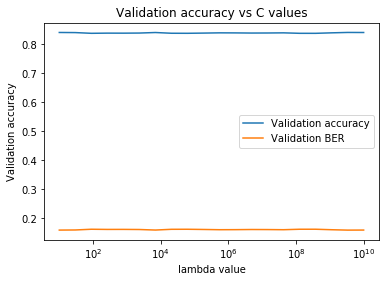


C value for highest accuracy is: 3359818286.2837744
Best validation accuracy is: 0.84155


In [20]:
C_values = np.logspace(1, 10, num = 20)
accs = []
BERs = []
loop_count = 0
for C_value in C_values:
    loop_count += 1
    if loop_count % 5 == 0: print(loop_count, end = ', ')
    clf = LogisticRegression(C = C_value).fit(LR_feat_val, LR_labels_val)
    predicitons = clf.predict(LR_feat_train)
    acc, BER = balanced_error_rate(predicitons, LR_labels_train)
    # acc = clf.score(LR_feat_val, LR_labels_val)
    accs.append(acc)
    BERs.append(BER)

plt.plot(C_values, accs, label='Validation accuracy')
plt.plot(C_values, BERs, label='Validation BER')
plt.ylabel('Validation accuracy')
plt.xlabel('lambda value'), plt.xscale('log')
plt.title('Validation accuracy vs C values')
plt.legend()
plt.show()

indx = accs.index(max(accs))
print('\nC value for highest accuracy is:', C_values[indx])
print('Best validation accuracy is:', accs[indx])

In [ ]:
clf2.coef_

In [24]:
# C = 200 0.68983 accuracy validation size 40000
# C = 300 
clf1 = LogisticRegression(C = C_values[indx]).fit(LR_feat_train, LR_labels_train)
# clf1 = LogisticRegression(C = 0.003359818286283781).fit(LR_feat_train, LR_labels_train)
clf2 = LogisticRegression(C = 300).fit(LR_feat_val, LR_labels_val)
def predict_datapoint_new(user, book_predict):
    feat = np.array(feature((user, book_predict,_), mode = 'train'))
    feat = feat.reshape(1, -1)
    prediction = clf.predict(feat)       
    return prediction

# WRITING PREDICTIONS TO FILE

In [25]:
# test_set = []
# for l in open("pairs_Read.txt"):
#     if l.startswith("userID"): # it's just the header
#         continue
#     user, book = l.strip().split('-') # it is a datapoint
#     test_set.append((user, book, _))

# X_test   = np.array([feature(d, 'test') for d in test_set])
# y_test   = [int(rating) >= 0 for _, _, rating in test_set]

In [29]:
clf2 = LogisticRegression(C = 300).fit(LR_feat_val, LR_labels_val)

In [30]:
len(LR_feat_val[0])

11

In [31]:
pos_count = 0
def predict_datapoint_new(clf, user, book):
    feat = np.array(feature((user, book, _), 'test'))
    feat = feat.reshape(1, -1)
    prediction = clf.decision_function(feat)       
    return prediction

count = 0;
userPredictions = defaultdict(list)
userPredictions2D = defaultdict(lambda: defaultdict(set))

# confidence_scores = clf2.decision_function(X_test)

with open("predictions_Read.txt", 'w') as predictions:
    for l in open("pairs_Read.txt"):
        if l.startswith("userID"): # it's just the header
            predictions.write(l)
            continue
        user, book = l.strip().split('-') # it is a datapoint
        userPredictions[user].append((predict_datapoint_new(clf2, user, book), book))

for user in userPredictions:
    userPredictions[user].sort(reverse = True)
    books = [d[1] for d in userPredictions[user]]
    for i in range(len(books)):
        userPredictions2D[user][books[i]] = 0
    for i in range(int(len(books)/2)):
        userPredictions2D[user][books[i]] = 1

count = 0
with open("predictions_Read.txt", 'w') as predictions:
    for l in open("pairs_Read.txt"):
        if l.startswith("userID"): # it's just the header
            predictions.write(l)
            continue
        user, book = l.strip().split('-') # it is a datapoint
        prediction = userPredictions2D[user][book]
        if prediction:
            count += 1
            predictions.write(user + '-' + book + ",1\n")
        else:
            predictions.write(user + '-' + book + ",0\n")
print(count)

10000


In [ ]:
predictions1 = clf1.predict(X_test)
predictions2 = clf2.predict(X_test)
preds = (predictions1 + predictions2) * 1 > sum((predictions1 + predictions2) * 1) / len(preds)

In [ ]:
aver = sum((predictions1 + predictions2) * 1) / len(preds)

In [ ]:
pos_count = sum(clf2.predict(X_test))
print(pos_count)

offset = 0
conf_with_labels = zip(confidence_scores, [(d[0],d[1]) for d in test_set])
conf_with_labels = list(conf_with_labels)
conf_with_labels.sort(reverse = True)
positives = conf_with_labels[:pos_count + offset]
negatives = conf_with_labels[pos_count + offset:]
positives = [d[1] for d in positives]
negatives = [d[1] for d in negatives]
print(len(positives))
print(len(negatives))

In [ ]:
pos_count = 0
def predict_datapoint_new(clf, user, book):
    feat = np.array(feature((user, book,_), 'test'))
    feat = feat.reshape(1, -1)
    prediction = clf.predict(feat)       
    return prediction

with open("predictions_Read.txt", 'w') as predictions:
    for l in open("pairs_Read.txt"):
        if l.startswith("userID"): # it's just the header
            predictions.write(l)
            continue
        user, book = l.strip().split('-') # it is a datapoint
        prediction1 = predict_datapoint_new(clf1, user, book)
        prediction2 = predict_datapoint_new(clf2, user, book)
        prediction = (prediction1 + prediction2) * 1 > aver
        if prediction:
            pos_count += 1
            predictions.write(user + '-' + book + ",1\n")
        else:
            predictions.write(user + '-' + book + ",0\n")

In [ ]:
print(pos_count)

In [ ]:
x = 3
def fun():
    global x
    x = 11
    return
fun()
print('x is currently', x)

In [ ]:
def fun1(x):
    def fun2():
        nonlocal x
        print('non local x is', x)
        x = -25
    return fun2()
x = 3
fun1(x)
print('x is currently', x)